In [1]:
import pandas as pd
import numpy as np
import networkx as nx
# import tensorflow as tf
# import tensorflow_gnn as tfgnn
# import urllib.request
# import matplotlib.pyplot as plt
# import io
# import zipfile
# import sys
#
# from difflib import SequenceMatcher
# from mpl_toolkits.basemap import Basemap
# from sklearn.model_selection import train_test_split
# from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [2]:
# edges = pd.read_csv('../data/twitch_gamers/large_twitch_edges.csv')
# nodes = pd.read_csv('../data/twitch_gamers/large_twitch_features.csv')
# df = pd.merge(edges, features, left_on='numeric_id_1', right_on='numeric_id')
# df.drop('numeric_id', axis=1, inplace=True)
# df.rename(columns={'numeric_id_1':'from', 'numeric_id_2': 'to'}, inplace=True)
# df[1000:3000].head()
# attributes = df.columns[2:]
# print(attributes)
# node_attr = df[attributes].to_dict('index')

In [3]:
nodes = pd.DataFrame(columns=['node', 'views', 'mature', 'life_time', 'dead_account', 'affiliate', 'label'])
n = 100
nodes['node'] = range(n)
nodes['views'] = np.random.randint(0,100000,size=n)
nodes['mature'] = np.random.randint(0,2,size=n)
nodes['life_time'] = np.random.randint(0,1000,size=n)
nodes['dead_account'] = np.random.randint(0,2,size=n)
nodes['affiliate'] = np.random.randint(0,2,size=n)
nodes['label'] = np.random.randint(0,2,size=n)
nodes

,node,views,mature,life_time,dead_account,affiliate,label
0,0,82991,0,251,1,0,0
1,1,21234,0,141,1,0,1
2,2,81351,0,344,1,0,1
3,3,24184,0,322,1,0,0
4,4,76885,0,913,1,0,0
...,...,...,...,...,...,...,...
95,95,97814,0,497,0,1,0
96,96,48321,1,471,0,1,0
97,97,26923,1,695,0,0,1
98,98,78410,1,440,1,0,0


In [4]:
edges = pd.DataFrame(columns=['source', 'target'])
edges['source'] = np.random.randint(0,100,size=2*n)
edges['target'] = np.random.randint(0,100,size=2*n)
edges = edges.drop_duplicates()
edges

,source,target
0,42,62
1,3,62
2,65,57
3,48,88
4,73,94
...,...,...
195,29,28
196,98,48
197,62,97
198,76,60


In [112]:
from sklearn.preprocessing import StandardScaler
import torch

X = np.asarray(nodes[['node', 'views', 'mature', 'life_time', 'dead_account', 'affiliate']].values)
y = np.asarray(nodes[['label']].values).ravel()

G = nx.from_pandas_edgelist(edges, source='source', target='target')

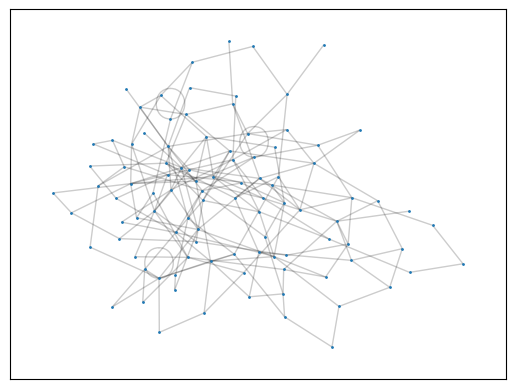

In [6]:
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx_edges(G, pos, alpha=0.2)
nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), node_size=1)

In [7]:
adj = nx.to_scipy_sparse_array(G).tocoo()
row = torch.from_numpy(adj.row.astype(np.int64))
col = torch.from_numpy(adj.col.astype(np.int64))
edge_index = torch.stack([row, col], dim=0)


# normalizing degree values
scale = StandardScaler()


In [113]:
print(X.shape)
print(y.shape)
print(edge_index.shape)

(100, 6)
(100,)
torch.Size([2, 383])


In [114]:

from sklearn.model_selection import train_test_split
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.loader import DataLoader

class CustomDataset(InMemoryDataset):
    def __init__(self, transform=None):
        super(CustomDataset, self).__init__('.', transform, None, None)

        data = Data(x=X, y=y, edge_index=edge_index)
        data.x = torch.from_numpy(X).type(torch.float32)
        data.y = torch.from_numpy(y).type(torch.long)
        data.num_classes = 2

        # splitting the data into train, validation and test
        X_train, X_test, y_train, y_test = train_test_split(pd.Series(X[:,0]),pd.Series(y),test_size=0.30,random_state=42)

        # create train and test masks for data
        train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        train_mask[X_train.index] = True
        test_mask[X_test.index] = True
        data['train_mask'] = train_mask
        data['test_mask'] = test_mask

        self.data, self.slices = self.collate([data])


dataset = CustomDataset()
data = dataset[0]


In [116]:
data.y

tensor([0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
        0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
        0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0,
        0, 1, 0, 1])

In [108]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

# GCN model with 2 layers
class Net(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Net, self).__init__()
        self.conv1 = GCNConv(input_dim, 16)
        self.conv2 = GCNConv(16, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [ ]:
# from torch_geometric.datasets import Planetoid
#
# dataset = Planetoid(root='/tmp/Cora', name='Cora')

In [137]:
from torch import optim
import torch.nn.functional as F

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = dataset[0].to(device)

# Define the GNN model
input_dim = dataset.num_node_features  # Number of input features
hidden_dim = 64  # Number of hidden units
output_dim = dataset.num_classes  # Number of output classes
model = Net(input_dim, output_dim).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
# criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 100
# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    # Zero the gradients
    optimizer.zero_grad()
    # Forward pass
    outputs = model(data)

    # Compute loss
    loss = criterion(outputs[data.train_mask], data.y[data.train_mask])

    # Backward pass and optimize
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    epoch_loss = running_loss
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    # # Evaluate the model
    # accuracy = evaluate(model, dataloader)
    # print(f'Accuracy on the validation set: {accuracy:.2%}')

Epoch 1/100, Loss: 31671.5098
Epoch 2/100, Loss: 31859.7031
Epoch 3/100, Loss: 31455.9531
Epoch 4/100, Loss: 29371.1895
Epoch 5/100, Loss: 25880.5938
Epoch 6/100, Loss: 30861.9922
Epoch 7/100, Loss: 27831.3652
Epoch 8/100, Loss: 32999.8125
Epoch 9/100, Loss: 26945.0469
Epoch 10/100, Loss: 27302.1250
Epoch 11/100, Loss: 25506.8223
Epoch 12/100, Loss: 20542.7910
Epoch 13/100, Loss: 29936.9648
Epoch 14/100, Loss: 25427.1328
Epoch 15/100, Loss: 28500.0703
Epoch 16/100, Loss: 23689.2578
Epoch 17/100, Loss: 21259.9902
Epoch 18/100, Loss: 25074.1641
Epoch 19/100, Loss: 26295.7852
Epoch 20/100, Loss: 26836.6133
Epoch 21/100, Loss: 26697.4062
Epoch 22/100, Loss: 23764.6758
Epoch 23/100, Loss: 21787.7480
Epoch 24/100, Loss: 25776.7578
Epoch 25/100, Loss: 22415.9004
Epoch 26/100, Loss: 21250.1973
Epoch 27/100, Loss: 19028.7871
Epoch 28/100, Loss: 21678.8223
Epoch 29/100, Loss: 19895.2891
Epoch 30/100, Loss: 20623.2148
Epoch 31/100, Loss: 21164.4453
Epoch 32/100, Loss: 22970.6973
Epoch 33/100, Los

In [138]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.4333
